In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 타이타닉 생존자 예측

# 1) 캐글 데이터 다운로드 및 데이터 확인

In [2]:
test_df = pd.read_csv("C:/machine_python/test.csv")
train_df = pd.read_csv("C:/machine_python/train.csv")
combine = [train_df, test_df]
# 데이터 변수 확인
print(train_df.columns.values)
print(train_df['Survived'].value_counts())
# 사망: 549 / 생존: 342

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']
0    549
1    342
Name: Survived, dtype: int64


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train_df.shape
# 891개 행, 12개 열

(891, 12)

In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
test_df.shape
# 테스트 데이터는 훈련 데이터로 학습시킨 모델을 통해
# 라벨링을 해야하므로 타깃(survived) 열이 빠진 상태

(418, 11)

In [7]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


훈련 자료 샘플 수: 891 / 훈련 자료 샘플 내 생존율: 38.38%

# 2) 결손치 처리
### train_df - age, cabin, embarked 결측치 존재
### test_df - age, fare, cabin 결측치 존재

In [8]:
test_df['Survived']=999  #target변수에 999넣기
combine = pd.concat([train_df, test_df], axis=0, ignore_index=True)

<AxesSubplot:>

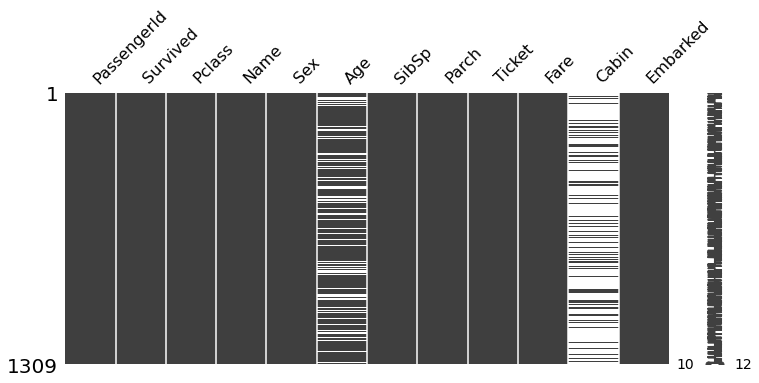

In [9]:
import missingno as msno
msno.matrix(combine, figsize=(12,5))
# Age, Cabin Na값 많음
# another way : combine.isnull().sum()

In [10]:
for col in combine.columns:
    na = 'column: {:>10}/t Percent of NaN value: {:.2f}%'.format(col,
    100*(combine[col].isnull().sum()/combine[col].shape[0]))
    print(na)
# Age는 평균으로 Embarked는 많이 차지하는 것으로 결측치를 처리
# Cabine 변수는 70%이상 na값이므로 제거

column: PassengerId/t Percent of NaN value: 0.00%
column:   Survived/t Percent of NaN value: 0.00%
column:     Pclass/t Percent of NaN value: 0.00%
column:       Name/t Percent of NaN value: 0.00%
column:        Sex/t Percent of NaN value: 0.00%
column:        Age/t Percent of NaN value: 20.09%
column:      SibSp/t Percent of NaN value: 0.00%
column:      Parch/t Percent of NaN value: 0.00%
column:     Ticket/t Percent of NaN value: 0.00%
column:       Fare/t Percent of NaN value: 0.08%
column:      Cabin/t Percent of NaN value: 77.46%
column:   Embarked/t Percent of NaN value: 0.15%


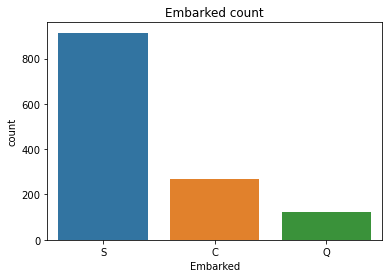

In [11]:
# Embarked 결측치 처리를 위해 어떤 경우가 가장 많은지 알아보기
bar = sns.countplot('Embarked', data=combine)
bar.set_title('Embarked count')
plt.show()

In [12]:
# Embarked 결측치 처리
combine['Embarked'].replace({np.nan:'S'}, inplace=True)

In [13]:
# Fare 결측치 처리
combine['Fare'].fillna(value=combine['Fare'].mean(), inplace=True)

In [14]:
# Age 결측치 처리하기
combine['Age'].fillna(value=combine['Age'].mean(), inplace=True)

In [15]:
for col in combine.columns:
    na = 'column: {:>10}/t Percent of NaN value: {:.2f}%'.format(col,
    100*(combine[col].isnull().sum()/combine[col].shape[0]))
    print(na)

column: PassengerId/t Percent of NaN value: 0.00%
column:   Survived/t Percent of NaN value: 0.00%
column:     Pclass/t Percent of NaN value: 0.00%
column:       Name/t Percent of NaN value: 0.00%
column:        Sex/t Percent of NaN value: 0.00%
column:        Age/t Percent of NaN value: 0.00%
column:      SibSp/t Percent of NaN value: 0.00%
column:      Parch/t Percent of NaN value: 0.00%
column:     Ticket/t Percent of NaN value: 0.00%
column:       Fare/t Percent of NaN value: 0.00%
column:      Cabin/t Percent of NaN value: 77.46%
column:   Embarked/t Percent of NaN value: 0.00%


# 3) 문자열 처리

In [16]:
sex_mapping = {"male":0, "female":1}
train_df['Sex'] = train_df['Sex'].map(sex_mapping)
test_df['Sex'] = test_df['Sex'].map(sex_mapping)
combine = pd.concat([train_df, test_df], axis=0, ignore_index=True)

In [17]:
# label encoding
from sklearn import preprocessing

def encode_features(dataDF):
    features = ['Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder() #레이블 인코더 객체 생성
        le = le.fit(dataDF[feature]) #fit으로 레이블 인코딩 수행
        dataDF[feature] = le.transform(dataDF[feature]) #transform으로 인코딩 수행
                
    return dataDF

combine = encode_features(combine)
combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,2
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,2


In [18]:
# 훈련에 사용하지 않을 column 삭제
combine.drop(columns=['Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin'], inplace=True)
combine.head(2)

,PassengerId,Survived,Pclass,Sex,Embarked
0,1,0,3,0,2
1,2,1,1,1,0


# 4) 전처리 수행 

In [19]:
# 레이블 인코딩 수행
def format_features(df):
    features = ['Embarked'] #레이블 인코딩
    for feature in features:
        le = LabelEncoder() #객체 생성
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

In [20]:
# 앞에서 설정한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [39]:
# 데이터 학습, 모델 생성 및 평가에 필요한 패키지들
# from sklearn.tree import DecisionTreeClassifier # 의사결정나무
# from sklearn.ensemble import RandomForestClassifier # 랜덤 포레스트
# from sklearn.naive_bayes import GaussianNB # 나이브 베이즈 분류
# from sklearn.svm import SVC # 서포트 벡터 머신
# from sklearn.linear_model import LogisticRegression # 로지스틱 회귀

# 5) Survived 속성을 y로 나머지 피쳐를 X로 만듦

In [21]:
# 피처 데이터세트 x, 레블 데이터세트 y추출(슬라이싱)
drop_col = ['Survived']
X = combine.drop(drop_col, axis=1)
y = combine['Survived']

# 6) 학습/테스트 데이터 세트 분리

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, combine.Survived, stratify=combine.Survived, test_size=0.2,random_state=2021
)

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1047, 4), (262, 4), (1047,), (262,))

In [24]:
y_test

732       0
230       1
1165    999
1218    999
845       0
       ... 
1087    999
662       0
801       1
1082    999
163       0
Name: Survived, Length: 262, dtype: int64

# 7) 적용할 알고리즘 선정: 결정 트리 – DecisionTreeClassifier

In [25]:
# 결정트리
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
# 과정과 하이퍼 파라미터 튜닝을 동시에

In [26]:
params = {
    'max_depth':[2,4,6],
    'min_samples_split':[2,3,4]
}

In [27]:
# 객체 생성 --> 모델 생성, 괄호 안은 Hyper Parameter
dtc = DecisionTreeClassifier(random_state=2021)
grid_dtc = GridSearchCV(dtc, param_grid=params, cv=5, scoring='accuracy')

# 8) 학습, 예측 및 평가

In [28]:
grid_dtc.fit(X_train,y_train)
grid_dtc.best_score_

0.8729505582137159

In [29]:
grid_dtc.best_params_

{'max_depth': 4, 'min_samples_split': 2}

In [30]:
estimator = grid_dtc.best_estimator_

In [31]:
from sklearn.metrics import accuracy_score
pred = estimator.predict(X_test)
accuracy_score(y_test, pred)

0.8625954198473282